<a href="https://colab.research.google.com/github/Abhishek92kumar/LJMU/blob/main/exploring_PubLayNet_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PubLayNet Dataset

PubLayNet is a large dataset of document images from PubMed Central Open Access Subset. Each document’s layout is annotated with both bounding boxes and polygonal segmentations.

The dataset is open sourced by IBM Research Australia and is [available to download freely](https://developer.ibm.com/exchanges/data/all/publaynet/) on the IBM Developer [Data Asset Exchange](http://ibm.biz/data-exchange). 

This notebook can be found on [GitHub](https://github.com/ibm-aur-nlp/PubLayNet) and [Watson Studio](https://dataplatform.cloud.ibm.com/analytics/notebooks/v2/43cb95d9-6c3e-479c-a189-8c9ff3524ec1/view?access_token=bb8ce645cf114b5f5512ae2eb9c7badcf0927f313e8f76b8138d0701289484e6).

## Download and Extract the Dataset

Since the dataset is huge (~100GB), here we will be downloading a small subset of the data and extract it. 

In [1]:
# importing prerequisites
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
fname = 'examples.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)

6461141

In [3]:
# Extracting the dataset
tar = tarfile.open(fname)
tar.extractall()
tar.close()

In [4]:
# Verifying the file was extracted properly
data_path = "examples/"
path.exists(data_path)

True

## Visualizing the Data

In this section, we visualize the annotations file by overlaying it on the underlying image.

In [5]:
# Define color code
colors = {'title': (255, 0, 0),
          'text': (0, 255, 0),
          'figure': (0, 0, 255),
          'table': (255, 255, 0),
          'list': (0, 255, 255)}

In [6]:
# Function to viz the annotation
def markup(image, annotations):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw segmentation
        draw.polygon(annotation['segmentation'][0],
                     fill=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (64,))
        # Draw bbox
        draw.rectangle(
            (annotation['bbox'][0],
             annotation['bbox'][1],
             annotation['bbox'][0] + annotation['bbox'][2],
             annotation['bbox'][1] + annotation['bbox'][3]),
            outline=colors[samples['categories'][annotation['category_id'] - 1]['name']] + (255,),
            width=2
        )
        # Draw label
        w, h = draw.textsize(text=samples['categories'][annotation['category_id'] - 1]['name'],
                             font=font)
        if annotation['bbox'][3] < h:
            draw.rectangle(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + annotation['bbox'][2] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0] + annotation['bbox'][2],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
        else:
            draw.rectangle(
                (annotation['bbox'][0],
                 annotation['bbox'][1],
                 annotation['bbox'][0] + w,
                 annotation['bbox'][1] + h),
                fill=(64, 64, 64, 255)
            )
            draw.text(
                (annotation['bbox'][0],
                 annotation['bbox'][1]),
                text=samples['categories'][annotation['category_id'] - 1]['name'],
                fill=(255, 255, 255, 255),
                font=font
            )
    return np.array(image)

In [7]:
# Parse the JSON file and read all the images and labels
with open('examples/samples.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

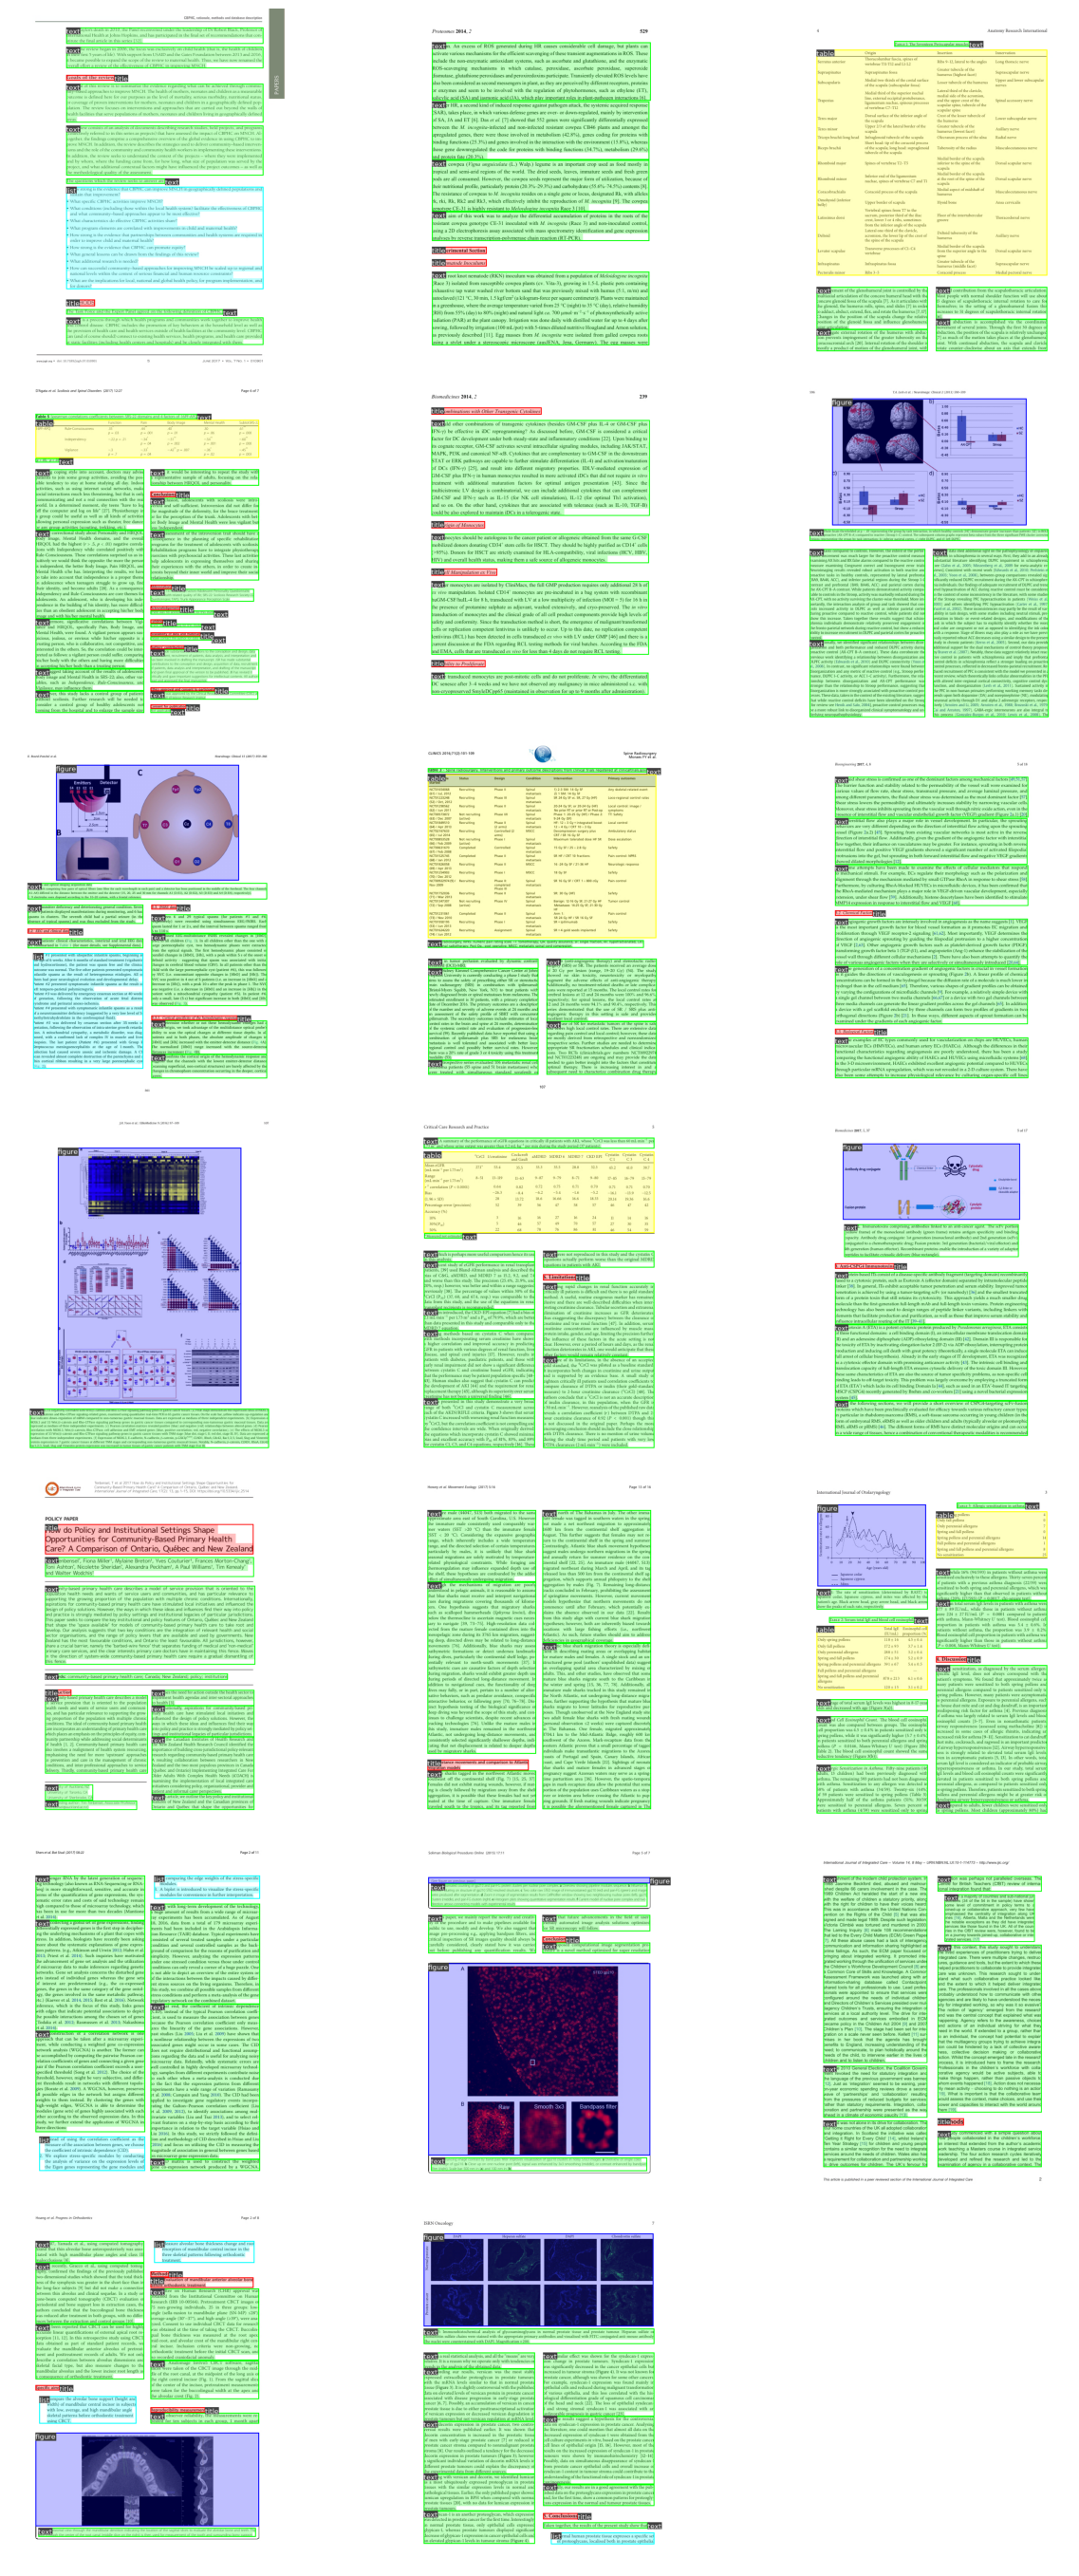

In [8]:
# Visualize annotations
font = ImageFont.truetype("examples/DejaVuSans.ttf", 15)
fig=plt.figure(figsize=(16, 100)) 
for i, (_, image) in enumerate(images.items()):
    with Image.open(image['file_name']) as img:
        ax = plt.subplot(len(images), 3, i + 1)
        ax.imshow(markup(img, image['annotations']))
        ax.axis('off')
plt.subplots_adjust(hspace=0, wspace=0)

# Exploring the training dataset

In [9]:
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.0 MB/s eta 0:00:00


In [10]:
import webdataset as wds
import pprint
import numpy as np
from itertools import islice
import torch
pp = pprint.PrettyPrinter(indent=2, compact=True, width=150, depth=2).pprint
cache_dir = None

# Loading PubLayNet from the Web

Datasets are accessible directly over the web. However, you can also store them locally, in network file systems, or in any object store.

In [11]:
urls =  "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz"
# urls =  "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/publaynet.tar.gz"
# urls =  "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz"

Datasets are just `.tar` archives containing training files. For PubLayNet, each training sample consists of a `.png` file and a corresponding `.json` file.

In [12]:
!curl {urls} | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  24.9M      0  0:00:12  0:00:12 --:--:-- 22.6M


In [13]:
import json
f = open('/content/publaynet/train.json',)
# f = open('examples/samples.json',)

# thing_classes  = []
# category_name_to_id = {}
# id_to_category_name ={}
# data_annotations=[]
data = json.load(f)
# for i in data['categories']:
#     thing_classes.append(i['name'])
#     print(i)
    # category_name_to_id[i['name']]=i['id']
    # id_to_category_name.append(i['id'])
    # id_to_category_name[i['id']= i['name']]
f.close()

In [14]:
thing_classes  = []
category_name_to_id = {}
id_num =[]
id_to_category_name ={}
data_annotations=[]
for i in data['categories']:
    thing_classes.append(i['name'])
    category_name_to_id[i['name']]=i['id']
print(category_name_to_id)
print(thing_classes)

{'text': 1, 'title': 2, 'list': 3, 'table': 4, 'figure': 5}
['text', 'title', 'list', 'table', 'figure']


In [15]:
id_to_category_name = {v: k for k, v in category_name_to_id.items()}
id_to_category_name

{1: 'text', 2: 'title', 3: 'list', 4: 'table', 5: 'figure'}

In [16]:
category  = []
category_name_to_id = {}
data_annotations=[]

for i in data['annotations']:
    category.append(id_to_category_name[i['category_id']] )
    # print(i)
    # category_name_to_id[i['category_id']]=i['id']
# category

In [17]:
len(category)

3263046

In [18]:
import pandas as pd
category =pd.Index(category)
category.value_counts()


text      2343356
title      627125
figure     109292
table      102514
list        80759
dtype: int64

<Axes: >

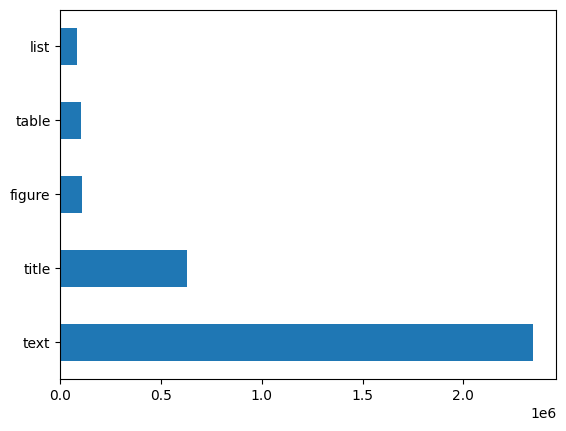

In [19]:
category.value_counts().plot(kind='barh')


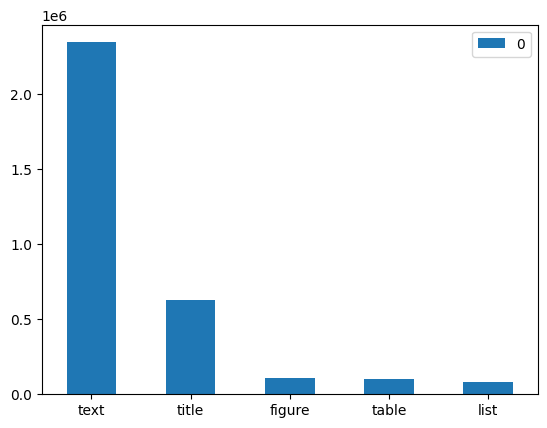

In [20]:
# index = ['text', 'title', 'list', 'table', 'figure']
# {'supercategory': '', 'id': 1, 'name': 'text'}
# {'supercategory': '', 'id': 2, 'name': 'title'}
# {'supercategory': '', 'id': 3, 'name': 'list'}
# {'supercategory': '', 'id': 4, 'name': 'table'}
# {'supercategory': '', 'id': 5, 'name': 'figure'}
  
df = pd.DataFrame(category.value_counts())
ax = df.plot.bar(rot=0)

(Text(0.5, 1.08, 'Instance Class Distribution (Training set)'),)

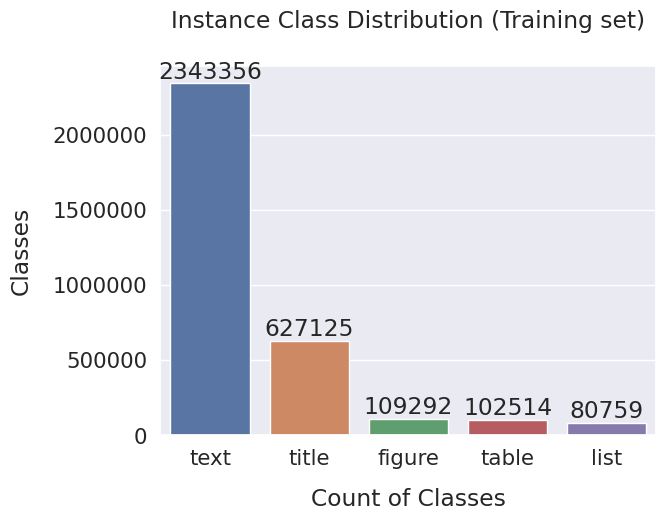

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.4)

ax =sns.barplot(x=category.value_counts().index, y=category.value_counts())
plt.xlabel("Count of Classes", labelpad=14)
plt.ylabel("Classes", labelpad=14)
plt.ticklabel_format(style='plain', axis='y')

ax.bar_label(ax.containers[0], labels=[f'{x.get_height():.0f}' for x in ax.containers[0]])

plt.title('Instance Class Distribution (Training set)', y=1.08),